# Assignment 4: Build a Supervised Autoencoder.

### Name: [Matthew Halvorsen]

### Due Date: Friday 5/16/2025 11:59PM


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised learning?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.

![](https://drive.google.com/uc?export=view&id=1MUVwJhBoj4RXK7-YCG7UGbyAn8UQvenl)



## 0. You will do the following:

1. Build a standard dense autoencoder, visualize the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transforms such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottleneck layer with 2 as  output size.
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model (20 points)

In [4]:
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 =  Dense(256, name='enc_dense_1')(input_img)
encode2 = Dense(128, name='enc_dense_2')(encode1)
encode3 = Dense(64, name='enc_dense_3')(encode2)

bottleneck = Dense(2, name='bottleneck')(encode3)


decode1 = Dense(64, name='dec_dense_1')(bottleneck)
decode2 = Dense(128, name='dec_dense_2')(decode1)
decode3 = Dense(256, name='dec_dense_3')(decode2)
decode4 = Dense(784, name='dec_dense_4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_3 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_2 (Dense)             │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_3 (Dense)             │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_4 (Dense)             │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,266 (1.85 MB)

 Trainable params: 485,266 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters (5 points)

In [6]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [7]:
from tensorflow.keras import optimizers
'''
learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate))
'''
import keras_tuner as kt

def build_model(hp):
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    ae.compile(
        optimizer=optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return ae

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='tuner_results',
    project_name='ae_tuning'
)

In [8]:
'''
history = ae.fit(x_tr, x_tr,
                 batch_size=128,
                 epochs=100,
                 validation_data=(x_val, x_val))
'''
# 1. Run the hyperparameter search
tuner.search(
    x_tr, x_tr,              # autoencoder: input = target
    epochs=10,
    batch_size=128,
    validation_data=(x_val, x_val) # validation reconstruction loss
)

# 2. Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best learning rate:", best_hps.get('learning_rate'))

# 3. Get the best model and retrain it if needed
best_model = tuner.get_best_models(num_models=1)[0]

# (optional) retrain for more epochs with the best learning rate
history = best_model.fit(
    x_train, x_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_val, x_val))

Trial 3 Complete [00h 00m 09s]
val_loss: 0.057121723890304565

Best val_loss So Far: 0.057121723890304565
Total elapsed time: 00h 00m 27s
Best learning rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0625 - val_loss: 0.0568
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0562 - val_loss: 0.0561
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0561 - val_loss: 0.0562
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0561 - val_loss: 0.0561
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0561 - val_loss: 0.0561
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0561 - val_loss: 0.0561
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0562 - val_loss: 0.0561
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0561 - val_loss: 0.0560
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0561 - val_loss: 0.0560
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0560 - val_loss: 0.0560
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━

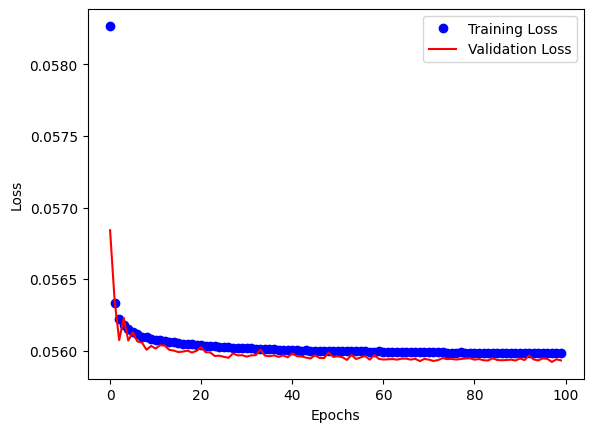

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images (5 points)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


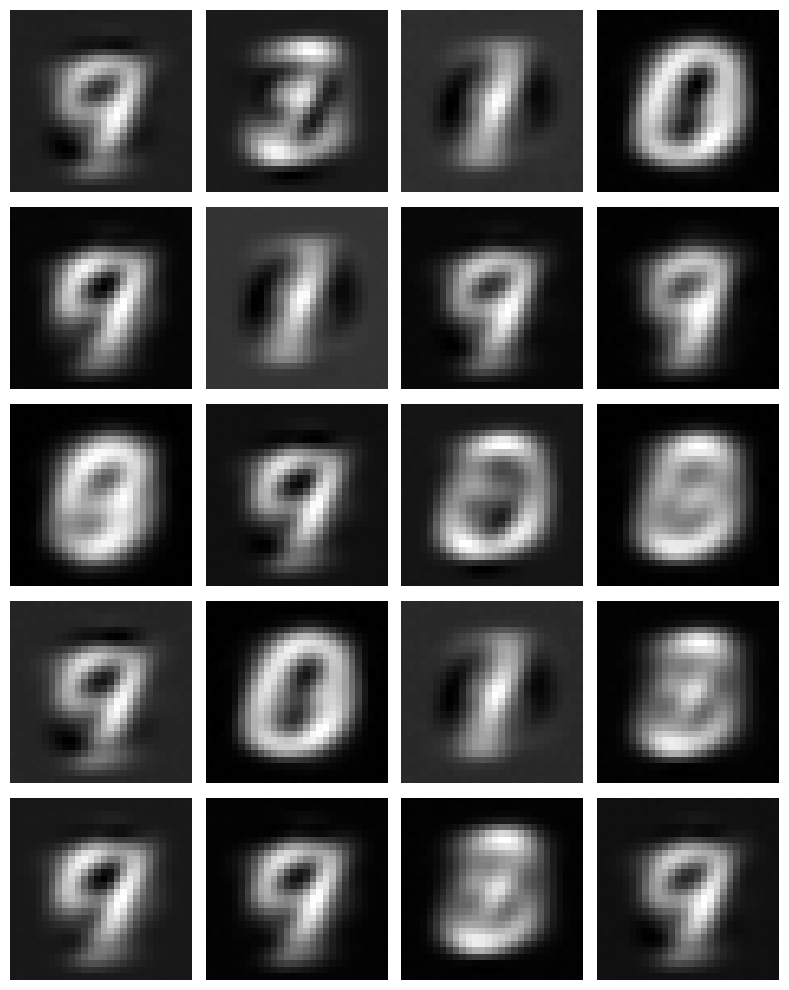

In [10]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [11]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0544
loss = 0.055697016417980194


### 2.5. Visualize the low-dimensional features

In [12]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_3 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,242 (946.26 KB)

 Trainable params: 242,242 (946.26 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shape of encoded_test: (10000, 2)


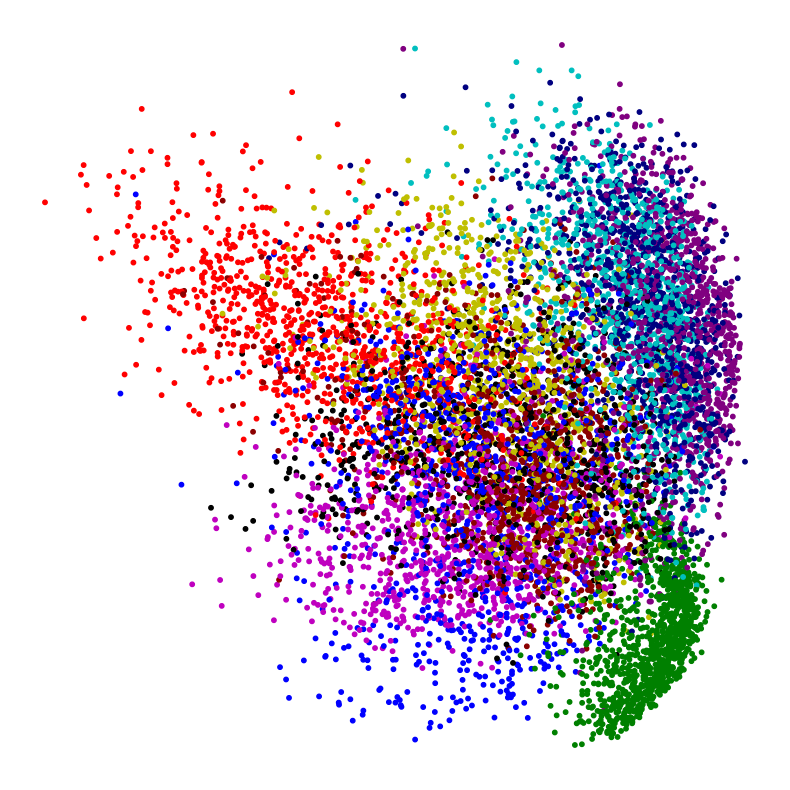

In [14]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantitatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [15]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [16]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,186 (71.04 KB)

 Trainable params: 18,186 (71.04 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr,
                        batch_size=32,
                        epochs=30,
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.2645 - loss: 2.1955 - val_acc: 0.3660 - val_loss: 1.8448
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3660 - loss: 1.7566 - val_acc: 0.3879 - val_loss: 1.5738
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3850 - loss: 1.5317 - val_acc: 0.4054 - val_loss: 1.4750
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4062 - loss: 1.4550 - val_acc: 0.4159 - val_loss: 1.4360
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4271 - loss: 1.4160 - val_acc: 0.4250 - val_loss: 1.4139
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4363 - loss: 1.4040 - val_acc: 0.4298 - val_loss: 1.4003
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4392 - loss: 1.3839 - val_acc: 0.4334 - val_loss: 1.3885
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4496 - loss: 1.3545 - val_acc: 0.4337 - val_loss: 1.3814
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.

![](https://drive.google.com/uc?export=view&id=1MUVwJhBoj4RXK7-YCG7UGbyAn8UQvenl)


### 4.1. Build the network (30 points)

In [28]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

num_classes = 10

input_img = Input(shape=(784,), name='input_img')

# encoder network

encode1 = Dense(256, activation='relu', name='enc_dense_1')(input_img)
encode2 = Dense(128, activation='relu', name='enc_dense_2')(encode1)
encode3 = Dense(64, activation='relu', name='enc_dense_3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck = bottleneck = Dense(2,  name='bottleneck')(encode3)

# decoder network
decode1 = Dense(64, activation='relu', name='dec_dense_1')(bottleneck)
decode2 = Dense(128, activation='relu', name='dec_dense_2')(decode1)
decode3 = Dense(256, activation='relu', name='dec_dense_3')(decode2)
decode4 = Dense(784, activation='relu', name='reconstruction')(decode3)

# build a classifier upon the bottleneck layer
cls1 = Dense(64, activation='relu', name='cls_dense_1')(bottleneck)
cls1 = Dropout(0.3, name='cls_dropout_1')(cls1)
cls2 = Dense(64, activation='relu', name='cls_dense_2')(cls1)
classifier3 = Dense(num_classes, activation='softmax', name='class_probs')(cls2)

In [29]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense_1 (Dense) │ (None, 256)       │    200,960 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense_2 (Dense) │ (None, 128)       │     32,896 │ enc_dense_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense_3 (Dense) │ (None, 64)        │      8,256 │ enc_dense_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 2)         │        130 │ enc_dense_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_1 (Dense) │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dense_1 (Dense) │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_2 (Dense) │ (None, 128)       │      8,320 │ dec_dense_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dropout_1       │ (None, 64)        │          0 │ cls_dense_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_3 (Dense) │ (None, 256)       │     33,024 │ dec_dense_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dense_2 (Dense) │ (None, 64)        │      4,160 │ cls_dropout_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction      │ (None, 784)       │    201,488 │ dec_dense_3[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_probs (Dense) │ (None, 10)        │        650 │ cls_dense_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 490,268 (1.87 MB)

 Trainable params: 490,268 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights.

In [31]:
from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(learning_rate=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr],
                  batch_size=32,
                  epochs=100,
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - class_probs_loss: 1.5133 - loss: 0.8384 - reconstruction_loss: 0.0818 - val_class_probs_loss: 0.5728 - val_loss: 0.3501 - val_reconstruction_loss: 0.0636
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - class_probs_loss: 0.5299 - loss: 0.3277 - reconstruction_loss: 0.0627 - val_class_probs_loss: 0.4512 - val_loss: 0.2852 - val_reconstruction_loss: 0.0596
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - class_probs_loss: 0.3332 - loss: 0.2258 - reconstruction_loss: 0.0592 - val_class_probs_loss: 0.4642 - val_loss: 0.2897 - val_reconstruction_loss: 0.0574
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - class_probs_loss: 0.2420 - loss: 0.1772 - reconstruction_loss: 0.0562 - val_class_probs_loss: 0.4638 - val_loss: 0.2878 - val_reconstruction_loss: 0.0556
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - class_probs_loss: 0.1915 - loss: 0.1505 - reconstruction_loss: 0.0547 - val_class_probs_loss: 0.2727 - val_lo

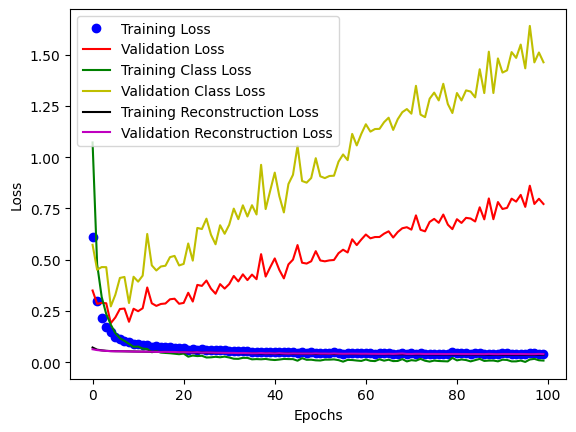

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']
class_loss = history.history['class_probs_loss']
val_class_loss = history.history['val_class_probs_loss']
reconstruction_loss = history.history['reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.plot(epochs, class_loss, 'g', label='Training Class Loss')
plt.plot(epochs, val_class_loss, 'y', label='Validation Class Loss')
plt.plot(epochs, reconstruction_loss, 'k', label='Training Reconstruction Loss')
plt.plot(epochs, val_reconstruction_loss, 'm', label='Validation Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question  (10 points)

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

Yes there is minor overfitting occuring, the main issue is that the weights were never tuned therefore the loss is stable around .5 indicating random guessing. Also focusing on tuning the hyper parameters to classification accuracy would help a lot as it would allow for there to be a good distinction between digits.

In [36]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

num_classes = 10

input_img = Input(shape=(784,), name='input_img')

# encoder network

encode1 = Dense(256, activation='relu', name='enc_dense_1')(input_img)
encode2 = Dense(128, activation='relu', name='enc_dense_2')(encode1)
encode3 = Dense(64, activation='relu', name='enc_dense_3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck = bottleneck = Dense(2,  name='bottleneck')(encode3)

# decoder network
decode1 = Dense(64, activation='relu', name='dec_dense_1')(bottleneck)
decode2 = Dense(128, activation='relu', name='dec_dense_2')(decode1)
decode3 = Dense(256, activation='relu', name='dec_dense_3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='reconstruction')(decode3)

# build a classifier upon the bottleneck layer
cls1 = Dense(64, activation='relu', name='cls_dense_1')(bottleneck)
cls1 = Dropout(0.3, name='cls_dropout_1')(cls1)
cls2 = Dense(64, activation='relu', name='cls_dense_2')(cls1)
classifier3 = Dense(num_classes, activation='softmax', name='class_probs')(cls2)
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense_1 (Dense) │ (None, 256)       │    200,960 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense_2 (Dense) │ (None, 128)       │     32,896 │ enc_dense_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_dense_3 (Dense) │ (None, 64)        │      8,256 │ enc_dense_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 2)         │        130 │ enc_dense_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_1 (Dense) │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dense_1 (Dense) │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_2 (Dense) │ (None, 128)       │      8,320 │ dec_dense_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dropout_1       │ (None, 64)        │          0 │ cls_dense_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_3 (Dense) │ (None, 256)       │     33,024 │ dec_dense_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dense_2 (Dense) │ (None, 64)        │      4,160 │ cls_dropout_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction      │ (None, 784)       │    201,488 │ dec_dense_3[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_probs (Dense) │ (None, 10)        │        650 │ cls_dense_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 490,268 (1.87 MB)

 Trainable params: 490,268 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
import keras_tuner as kt
from tensorflow.keras import optimizers

def build_model(hp):
    # (Re)build your SAE here or reuse `sae` if it’s created inside this fn
    # ...
    w_recon = hp.Float('w_recon', 0.2, 1.5, step=0.1)
    w_cls   = hp.Float('w_cls',   0.2, 2.0, step=0.1)
    lr      = hp.Choice('lr', [1e-2, 5e-3, 1e-3])

    sae.compile(
        optimizer=optimizers.RMSprop(lr),
        loss=['mean_squared_error','categorical_crossentropy'],
        loss_weights=[w_recon, w_cls],
        metrics={'class_probs':'accuracy'}
    )
    return sae

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_class_probs_accuracy', direction='max'),
    max_trials=20,
    directory='tune_loss_weights',
    project_name='sae'
)

tuner.search(
    x_tr, [x_tr, y_tr],
    validation_data=(x_val, [x_val, y_val]),
    epochs=10, batch_size=32
)

best_model = tuner.get_best_models(1)[0]
best_hps   = tuner.get_best_hyperparameters(1)[0]
print(best_hps.values)

Trial 20 Complete [00h 00m 24s]
val_class_probs_accuracy: 0.5746999979019165

Best val_class_probs_accuracy So Far: 0.9491999745368958
Total elapsed time: 00h 08m 04s
{'w_recon': 1.3, 'w_cls': 1.1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [55]:
import tensorflow as tf

best_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(best_hps.get('lr')),
    loss={
        'reconstruction': 'mean_squared_error',
        'class_probs': 'categorical_crossentropy'
    },
    loss_weights={
        'reconstruction': best_hps.get('w_recon'),
        'class_probs': best_hps.get('w_cls')
    },
    metrics={'class_probs': ['accuracy']}
)

history = best_model.fit(
    x_tr, {'reconstruction': x_tr, 'class_probs': y_tr},
    validation_data=(x_val, {'reconstruction': x_val, 'class_probs': y_val}),
    epochs=30,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ],
    verbose=1
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - class_probs_accuracy: 0.9937 - class_probs_loss: 0.0298 - loss: 0.0887 - reconstruction_loss: 0.0430 - val_class_probs_accuracy: 0.9458 - val_class_probs_loss: 1.3475 - val_loss: 1.5404 - val_reconstruction_loss: 0.0437 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - class_probs_accuracy: 0.9953 - class_probs_loss: 0.0205 - loss: 0.0776 - reconstruction_loss: 0.0424 - val_class_probs_accuracy: 0.9455 - val_class_probs_loss: 1.3019 - val_loss: 1.4899 - val_reconstruction_loss: 0.0435 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - class_probs_accuracy: 0.9941 - class_probs_loss: 0.0297 - loss: 0.0882 - reconstruction_loss: 0.0427 - val_class_probs_accuracy: 0.9460 - val_class_probs_loss: 1.3803 - val_loss: 1.5760 - val_reconstruction_loss: 0.0433 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - class_probs_accuracy: 0.9952 - class_probs_loss: 0.0

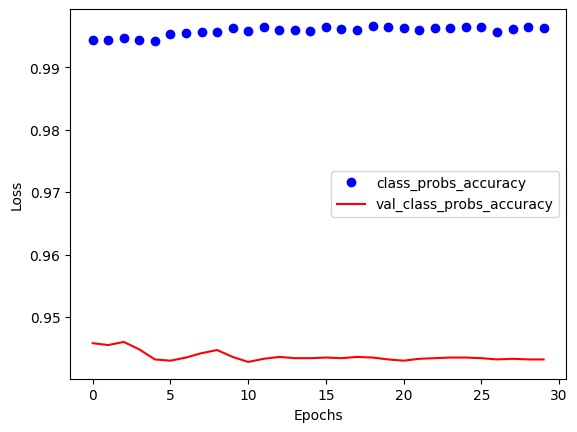

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

class_accuracy = history.history['class_probs_accuracy']
val_class_accuracy = history.history['val_class_probs_accuracy']

epochs = range(len(class_accuracy))

plt.plot(epochs, class_accuracy, 'bo', label='class_probs_accuracy')
plt.plot(epochs, val_class_accuracy, 'r', label='val_class_probs_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.3. Visualize the reconstructed test images

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


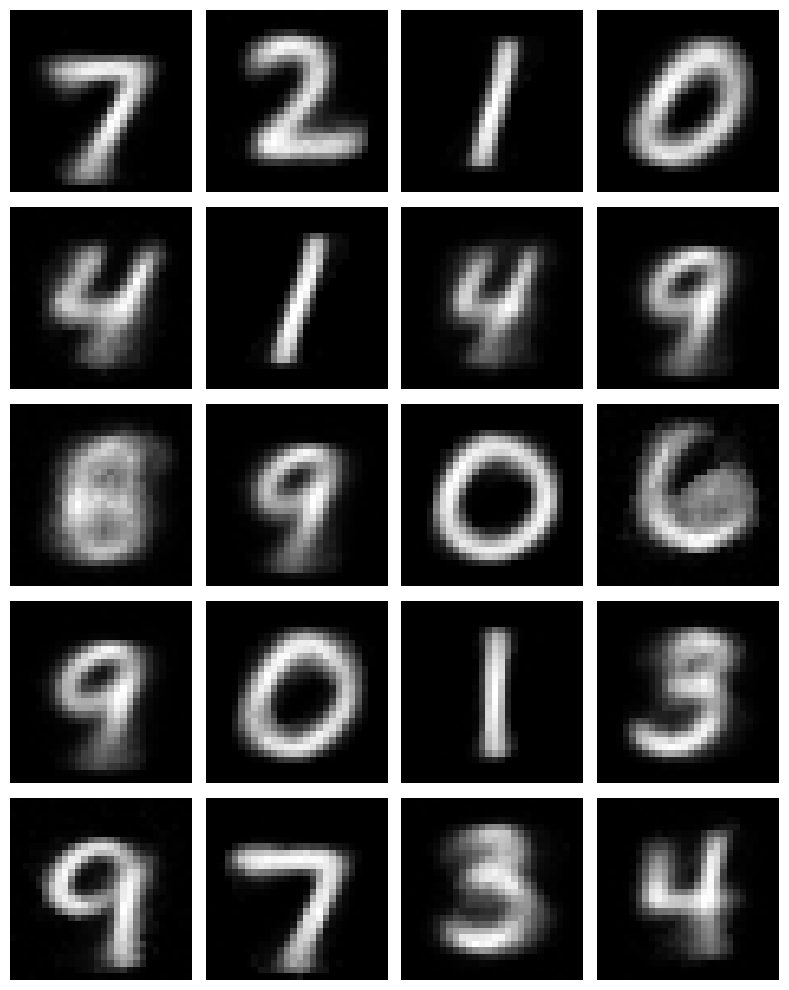

In [41]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features



In [42]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_3 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,242 (946.26 KB)

 Trainable params: 242,242 (946.26 KB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shape of encoded_test: (10000, 2)


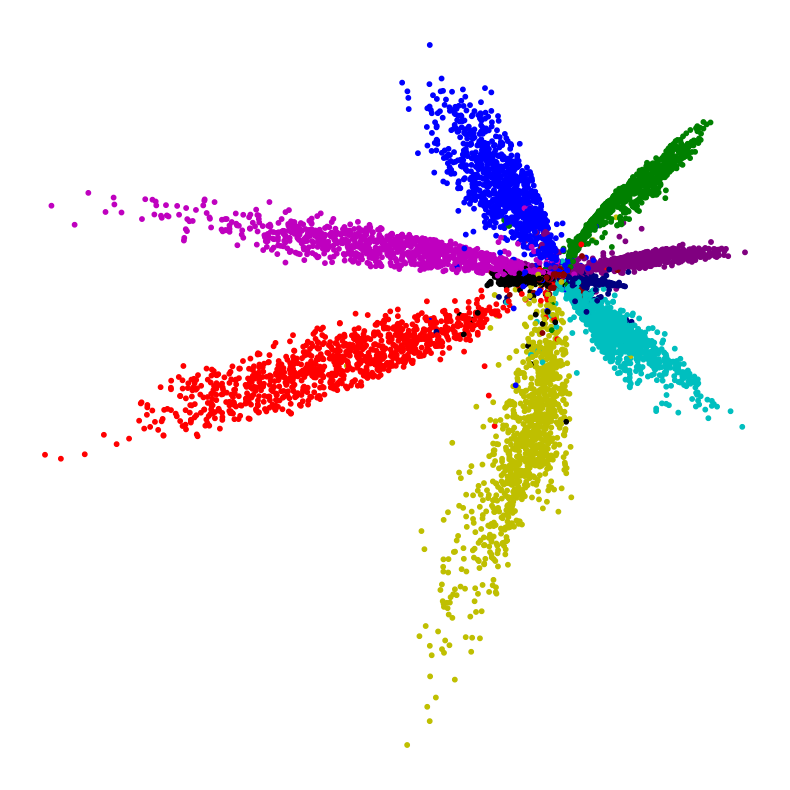

In [43]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [44]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [45]:
# build a classifier which takes the 2D features as input
from keras.layers import Input, Dense, Dropout
from keras import models, optimizers, regularizers

num_classes = 10

input_feat = Input(shape=(2,), name='bottleneck_2d')

# classifier body
x = Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4),
          name='cls_dense_1')(input_feat)
x = Dropout(0.3, name='cls_dropout_1')(x)

x = Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4),
          name='cls_dense_2')(x)

output = Dense(num_classes, activation='softmax', name='class_probs')(x)

classifier = models.Model(input_feat, output, name='bottleneck_classifier')
classifier.summary()

Model: "bottleneck_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bottleneck_2d (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_dense_1 (Dense)             │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_dropout_1 (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_dense_2 (Dense)             │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_probs (Dense)             │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,002 (19.54 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr,
                        batch_size=32,
                        epochs=30,
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.2272 - loss: 8.0592 - val_acc: 0.6789 - val_loss: 0.7648
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6169 - loss: 1.2491 - val_acc: 0.8567 - val_loss: 0.6003
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7780 - loss: 0.7226 - val_acc: 0.9241 - val_loss: 0.5485
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8851 - loss: 0.5263 - val_acc: 0.9349 - val_loss: 0.5138
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9338 - loss: 0.4037 - val_acc: 0.9381 - val_loss: 0.4900
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9585 - loss: 0.3234 - val_acc: 0.9389 - val_loss: 0.4857
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9650 - loss: 0.2691 - val_acc: 0.9394 - val_loss: 0.4823
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9686 - loss: 0.2264 - val_acc: 0.9408 - val_loss: 0.4762
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

#### Remark: (10 points)

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [65]:
# evaluate your model on the never-seen-before test data
# write your code here:
from sklearn.metrics import accuracy_score
# classifier head prediction
_, y_pred_probs = best_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_vec, axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))

Test accuracy: 0.9477


This is the accuracy score of the classification side of the autoencoder as the goal of the third model was to get the best classification of the minst dataset